In [1]:
import numpy as np
import torch
import pytagi
import random
import time
import os
import pickle
import psutil
import matplotlib.pyplot as plt
from tqdm import tqdm
from pytagi.nn import Linear, OutputUpdater, ReLU, Sequential
from pytagi import Utils
from pytagi.metric import classification_error
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, classification_report
from imblearn.over_sampling import ADASYN
from sklearn.preprocessing import MinMaxScaler
import shap
from sklearn.cluster import KMeans
import pandas as pd

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'STIXGeneral'

In [2]:
class MineralDataLoader:
    def __init__(
        self,
        features: np.ndarray,
        labels: np.ndarray,
    ):
        self.features = features
        self.labels = labels
        self.num_samples = features.shape[0]
        self.input_dim = features.shape[1]
        
        utils = Utils()
        self.hrc_softmax = utils.get_hierarchical_softmax(num_classes=2)
        
        y, y_idx, num_enc_obs = utils.label_to_obs(labels=labels, num_classes=2)
        
        self.y = y.astype(np.float32)
        self.y_idx = y_idx.astype(np.int32)
    
    def create_data_loader(self, batch_size: int, shuffle: bool = True):
        indices = np.arange(self.num_samples)
        
        if shuffle:
            np.random.shuffle(indices)
        
        # Calculate number of batches
        num_complete_batches = self.num_samples // batch_size
        
        for i in range(num_complete_batches):
            batch_indices = indices[i * batch_size:(i + 1) * batch_size]
            
            # Batch data
            batch_features = self.features[batch_indices].astype(np.float32)
            batch_y = self.y[batch_indices].astype(np.float32)
            batch_y_idx = self.y_idx[batch_indices].astype(np.int32)
            batch_labels = self.labels[batch_indices]
            
            yield batch_features, batch_y, batch_y_idx, batch_labels


In [3]:
class BinaryClassificationMetric:
    def __init__(self):
        self.num_classes = 2
        self.utils = Utils()
        self.hrc_softmax = self.utils.get_hierarchical_softmax(num_classes=2)
    
    def error_rate(self, m_pred: np.ndarray, v_pred: np.ndarray, label: np.ndarray) -> float:
        batch_size = m_pred.shape[0] // self.hrc_softmax.len
        pred, _ = self.utils.get_labels(
            m_pred, v_pred, self.hrc_softmax, self.num_classes, batch_size
        )
        return classification_error(pred, label)
    
    def get_predicted_labels(self, m_pred: np.ndarray, v_pred: np.ndarray) -> np.ndarray:
        batch_size = m_pred.shape[0] // self.hrc_softmax.len
        pred, _ = self.utils.get_labels(
            m_pred, v_pred, self.hrc_softmax, self.num_classes, batch_size
        )
        return pred

In [14]:
def get_pa_intersection(
    true_positive_rate_values: np.ndarray,
    proportion_of_area_values: np.ndarray,
    threshold_values: np.ndarray,
):
    true_positive_area_curve = LineString(np.column_stack((threshold_values, true_positive_rate_values)))
    proportion_of_area_values_curve = LineString(np.column_stack((threshold_values, 1 - proportion_of_area_values)))
    intersection = true_positive_area_curve.intersection(proportion_of_area_values_curve)
    return intersection.x, intersection.y

    # if hasattr(intersection, 'x') and hasattr(intersection, 'y'):
    #     return intersection.x, intersection.y
    # else:
    #     # Handle the case where there might be multiple intersections or none
    #     print("Warning: Couldn't find a single intersection point")
    #     return threshold_values.mean(), 0.5  # Return a default value



In [28]:
def plot_prediction_area_curves(
    true_positive_rate_values: np.ndarray,
    proportion_of_area_values: np.ndarray,
    threshold_values: np.ndarray,
    font_size: int = 10,
    fig_size: tuple = (3.333, 3.333)
):
    x, y = get_pa_intersection(true_positive_rate_values, proportion_of_area_values, threshold_values)

    fig = plt.figure(figsize=fig_size)
    ax1 = fig.add_subplot(111)
    ax2 = ax1.twinx()
    ax1.plot(threshold_values, true_positive_rate_values, "r-", label="Prediction rate")

    ax2.plot(threshold_values, proportion_of_area_values, "b-", label="Area")
    ax2.plot(x, 1 - y, "o", markersize=5, c="black", label="Intersection point") # Smaller marker
    ax1.set_ylim(0, 1.01)
    ax2.set_ylim(-0.01, 1)
    ax2.invert_yaxis()

    ax1.set_xlabel("Threshold", fontsize=font_size, labelpad=8)
    ax1.set_ylabel("True positive rate", color="r", fontsize=font_size, labelpad=8)
    ax2.set_ylabel("Proportion of area", color="b", fontsize=font_size, labelpad=8)
    
    ax1.tick_params(axis='y', colors='r', labelsize=font_size)
    ax2.tick_params(axis='y', colors='b', labelsize=font_size)
    ax1.tick_params(axis='x', labelsize=font_size)

    ax1.annotate(
        text="TPR: " + str(round(y, 2)),
        xy=(x, y),
        xytext=(x + threshold_values.max() * 0.2, y), 
        arrowprops=dict(
            arrowstyle="->,head_width=0.3,head_length=0.8",
            color='black',
            shrinkA=5, 
            shrinkB=5  
        ),
        verticalalignment="center",
        fontsize=font_size
    )
    fig.legend(loc='upper center', bbox_to_anchor=(0.5, 0.40), fontsize=font_size)
    
    plt.tight_layout(pad=0.5)
    return fig, x, y

In [29]:
def get_tagi_predictions(net, test_dataloader, metric, batch_size):
    all_preds = []
    all_probs = []
    all_labels = []
    
    test_batch_iter = test_dataloader.create_data_loader(batch_size, shuffle=False)
    net.eval()
    
    for x, _, _, label in tqdm(test_batch_iter, desc="Generating TAGI Predictions"):
        m_pred, v_pred = net(x)
        
        # get predictions and probabilities
        batch_size_local = m_pred.shape[0] // metric.hrc_softmax.len
        pred, probs = metric.utils.get_labels(
            m_pred, v_pred, metric.hrc_softmax, metric.num_classes, batch_size_local)
        
        all_preds.extend(pred)
        all_labels.extend(label)
        
        # handling probability shapes from hierarchical softmax
        if len(probs.shape) > 1:
            all_probs.extend(probs[:, 1] if probs.shape[1] > 1 else probs.flatten())
        else:
            if len(probs) == 2*len(pred):
                all_probs.extend(probs[1::2])
            else:
                all_probs.extend(probs)
    
    return np.array(all_preds), np.array(all_probs), np.array(all_labels)

In [30]:
def mineral_classification_main(
    num_epochs: int = 5,
    batch_size: int = 32,
    sigma_v: float = 0.5,
    is_tracking: bool = False,
    use_adasyn: bool = True, 
    random_state: int = 42,
    print_every: int = 10, 
):
    RANDOM_SEED = random_state

    process = psutil.Process(os.getpid())
    peak_ram = 0

    torch.manual_seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    random.seed(RANDOM_SEED)

    print_param_stat = True
    is_tracking = is_tracking if print_param_stat else False
    param_stat = ParamStatTable()

    if is_tracking:
        wandb_logger = WandBLogger(
            project_name="mineral_prospectivity",
            config={
                "sigma_v": sigma_v,
                "dataset": "mineral_prospectivity",
                "batch_size": batch_size,
                "num_epochs": num_epochs,
                "use_adasyn": use_adasyn, 
                "print_every": print_every,
            },
        )
        wandb_logger.init()

    X_train = torch.load('./data/dataset_train.pt').numpy()
    y_train = torch.load('./data/mineral_train.pt').numpy()
    X_test = torch.load('./data/dataset_test.pt').numpy()
    y_test = torch.load('./data/mineral_test.pt').numpy()
    
    if len(y_train.shape) == 2:
        y_train = y_train.ravel()
    if len(y_test.shape) == 2:
        y_test = y_test.ravel()
    
    X_train = X_train.astype(np.float32)
    X_test = X_test.astype(np.float32)
    y_train = y_train.astype(np.int32)
    y_test = y_test.astype(np.int32)
    
    print(f"Original training set: {X_train.shape[0]} samples, {X_train.shape[1]} features")
    print(f"Original training class distribution: {np.bincount(y_train)}")
    
    # apply ADASYN 
    if use_adasyn:
        adasyn = ADASYN(random_state=RANDOM_SEED)
        X_train, y_train = adasyn.fit_resample(X_train, y_train)
        print(f"After ADASYN - training set: {X_train.shape[0]} samples, {X_train.shape[1]} features")
        print(f"After ADASYN - training class distribution: {np.bincount(y_train)}")
    
    print(f"Testing set: {X_test.shape[0]} samples, {X_test.shape[1]} features")
    print(f"Testing class distribution: {np.bincount(y_test)}")
    
    train_dataloader = MineralDataLoader(X_train, y_train)
    test_dataloader = MineralDataLoader(X_test, y_test)
    
    metric = BinaryClassificationMetric()

    input_dim = X_train.shape[1]

    MINERAL_FNN = Sequential(
        Linear(input_dim, 32),
        ReLU(),  
        Linear(32, 32),
        ReLU(),
        # Linear(32, 32),
        # ReLU(),
        # Linear(32, 32),
        # ReLU(),
        Linear(32, 1),
    )
    
    net = MINERAL_FNN
    if pytagi.cuda.is_available():
        net.to_device("cuda")
    else:
        net.set_threads(8)

    def count_all_params(item):
        # if the item is a number, count it as 1 parameter.
        if isinstance(item, (int, float)):
            return 1
        # if it's a list or tuple, sum the counts of its sub-items.
        elif isinstance(item, (list, tuple)):
            return sum(count_all_params(sub_item) for sub_item in item)
        # ignore any other types (like None, strings, etc.)
        return 0

    # Get the collection of parameters
    all_model_params = net.parameters()
    total_params = count_all_params(all_model_params)

    print(f"TAGI - Total trainable parameters: {total_params:,}")

    if print_param_stat:
        net.preinit_layer()
        state_dict = net.state_dict()
        param_stat.record_params(state_dict)
        param_stat.print_current_parameter_distributions(topN=10)
        if is_tracking:
            log_data = param_stat.rows_to_dict()
            wandb_logger.log(log_data)

    out_updater = OutputUpdater(net.device)

    ### TRAINING
    error_rates = []
    train_error_rates = []  
    val_error_rates = []   
    test_error_rates = []   
    epoch_list = []     

    process = psutil.Process(os.getpid())
    overall_peak_ram_mb = 0 
    epoch_durations_list = []  
    
    var_y = np.full(
        (batch_size * metric.hrc_softmax.num_obs,), sigma_v**2, dtype=np.float32
    )
    pbar = tqdm(range(num_epochs), desc="Training Progress")
    epoch_durations_list = []
    print_var = True
    
    for epoch in pbar:
        epoch_start_time = time.time()
        epoch_list.append(epoch + 1)
        peak_ram_in_epoch_mb = 0
        
        batch_iter = train_dataloader.create_data_loader(batch_size=batch_size)
        net.train()
        epoch_errors = []
        
        for x, y, y_idx, label in batch_iter:
            m_pred, v_pred = net(x)  # Mean prediction and variance
            if print_var:
                print(
                    "Prior predictive -> E[v_pred] = ",
                    np.average(v_pred),
                    "+-",
                    np.std(v_pred),
                )
                print_var = False

            actual_batch_size = x.shape[0]
            if actual_batch_size != batch_size:
                var_y = np.full(
                    (actual_batch_size * metric.hrc_softmax.num_obs,), sigma_v**2, dtype=np.float32
                )

            out_updater.update_using_indices(
                output_states=net.output_z_buffer,
                mu_obs=y,
                var_obs=var_y,
                selected_idx=y_idx,
                delta_states=net.input_delta_z_buffer,
            )

            net.backward()
            net.step()

            batch_error = metric.error_rate(m_pred, v_pred, label)
            error_rates.append(batch_error)
            epoch_errors.append(batch_error)

            current_ram_mb = process.memory_info().rss / (1024 ** 2)
            peak_ram_in_epoch_mb = max(peak_ram_in_epoch_mb, current_ram_mb)
            overall_peak_ram_mb = max(overall_peak_ram_mb, current_ram_mb)

        # Calculate average training error for this epoch
        avg_train_error = sum(epoch_errors) / len(epoch_errors) if epoch_errors else 0
        train_error_rates.append(avg_train_error * 100) 
        
        should_print = (epoch + 1) % print_every == 0 or epoch == num_epochs - 1
        
        if print_param_stat and should_print:
            param_stat.record_params(net.state_dict())
            param_stat.print_current_parameter_distributions(topN=10)
            if is_tracking:
                log_data = param_stat.rows_to_dict()
                wandb_logger.log(log_data)

        # Testing
        correct = 0
        num_samples = 0
        test_batch_iter = test_dataloader.create_data_loader(batch_size, shuffle=False)
        net.eval()
        for x, _, _, label in test_batch_iter:
            m_pred, v_pred = net(x)

            # Prediction
            pred = metric.get_predicted_labels(m_pred, v_pred)
            correct += np.sum(pred == label)
            num_samples += len(label)

        test_error_rate = (1.0 - correct / num_samples) * 100
        test_error_rates.append(test_error_rate) 
        
        val_error_rates.append(test_error_rate)  
        
        if should_print:
            pbar.set_description(
                f"Epoch {epoch + 1}/{num_epochs} | training error: {avg_train_error*100:.7f}% | test error: {test_error_rate:.7f}%",
                refresh=True,
            )

        current_epoch_duration = time.time() - epoch_start_time
        epoch_durations_list.append(current_epoch_duration)
        print(f"Epoch {epoch+1} completed in {current_epoch_duration:.2f} seconds. Peak RAM in Epoch: {peak_ram_in_epoch_mb:.2f} MB")
    
    print(f"Final test error rate: {test_error_rate:.5f}%")

    model_save_path = 'tagi_adasyn_statistics.pth'
    torch.save(net.state_dict(), model_save_path)
    print(f"Trained TAGI model saved to {model_save_path}")
    
    return {
            "net": net,
            "train_dataloader": train_dataloader,
            "test_dataloader": test_dataloader,
            "metric": metric,
            "batch_size": batch_size,
            "train_error_rates": train_error_rates, 
            "test_error_rates": test_error_rates,   
            "epoch_durations": epoch_durations_list,
            "peak_ram_mb": overall_peak_ram_mb,
            "epochs_list": epoch_list
        }

In [ ]:
if __name__ == "__main__":
    training_results = mineral_classification_main(
        num_epochs=100,     
        batch_size=32,   
        sigma_v=5,
        use_adasyn=True,
        print_every=1
    )

    print("\n--- Final Summary ---")
    model_trained = training_results["net"]
    epoch_durations_list = training_results["epoch_durations"]
    peak_ram_mb = training_results["peak_ram_mb"] 

    # Average time per epoch with std
    if epoch_durations_list:
        avg_time = np.mean(epoch_durations_list)
        std_time = np.std(epoch_durations_list)
        print(f"TAGI - Average time per epoch: {avg_time:.2f} ± {std_time:.2f} seconds")

    # Overall peak RAM
    print(f"TAGI - Overall Peak RAM: {peak_ram_mb:.2f} MB")
    
    # Number of parameters
    def count_all_params(item):
        if isinstance(item, (int, float)): return 1
        elif isinstance(item, (list, tuple)): return sum(count_all_params(sub_item) for sub_item in item)
        return 0
    total_params = count_all_params(model_trained.parameters())
    print(f"TAGI - Total trainable parameters: {total_params:,}")

In [8]:
input_dim = 173  
net = Sequential(
    Linear(input_dim, 32),
    ReLU(),
    Linear(32, 32),
    ReLU(),
    Linear(32, 1),
)


model_save_path = 'tagi_adasyn_v1.pth'
net.load_state_dict(torch.load(model_save_path))

net.eval()

In [9]:
batch_size = 32
metric = BinaryClassificationMetric()

X_test = torch.load('./data/dataset_test.pt').numpy().astype(np.float32)
y_test = torch.load('./data/mineral_test.pt').numpy().ravel().astype(np.int32)

test_dataloader = MineralDataLoader(X_test, y_test)

In [ ]:
all_preds, all_probs, all_labels = get_tagi_predictions(net, test_dataloader, metric, batch_size)

np.save('tagi_all_preds.npy', all_preds)
np.save('tagi_all_probs.npy', all_probs)
np.save('tagi_all_labels.npy', all_labels)

In [ ]:
# epochs_list = training_results['epochs_list']
# train_errors = training_results['train_error_rates']
# test_errors = training_results['test_error_rates']
# 
# plt.figure(figsize=(10, 6))
# plt.plot(epochs_list, train_errors, 'b-', label='Training Error')
# plt.plot(epochs_list, test_errors, 'g-', label='Test Error')
# plt.xlabel('Epoch')
# plt.ylabel('Error Rate (%)')
# plt.title('TAGI Error Rate vs. Epoch')
# plt.legend()
# plt.grid(True)
# plt.show()

In [ ]:
# ROC plot
all_probs = np.load('tagi_all_probs.npy')
all_labels = np.load('tagi_all_labels.npy')

fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'TAGI ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('TAGI ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Confusion matrix
all_preds = np.load('tagi_all_preds.npy')
all_labels = np.load('tagi_all_labels.npy')

cm = confusion_matrix(all_labels, all_preds)
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Barren', 'Mineral'])

fig_cm, ax_cm = plt.subplots(figsize=(8, 6))
ax_cm.grid(False)

display.plot(
    ax=ax_cm,
    cmap=plt.cm.Blues,
    values_format='d'
)

ax_cm.axvline(0.5, color='gray', linewidth=1)
ax_cm.axhline(0.5, color='gray', linewidth=1)


font_size = 16
ax_cm.set_xlabel('Predicted label', fontsize=font_size, labelpad=10)
ax_cm.set_ylabel('True label', fontsize=font_size, labelpad=10)
ax_cm.tick_params(axis='both', which='major', labelsize=font_size)

for text in ax_cm.texts:
    text.set_fontsize(font_size)

plt.tight_layout()
plt.savefig('tagi_cm.pdf')
plt.show()

print(classification_report(all_labels, all_preds, target_names=['Barren', 'Mineral']))

In [ ]:
# PA curve
all_probs  = np.load('tagi_all_probs.npy')
all_labels = np.load('tagi_all_labels.npy')

num_thresholds = 100
threshold_values = np.linspace(all_probs.min(), all_probs.max(), num_thresholds)

tpr_values = np.zeros(num_thresholds)
area_prop_values = np.zeros(num_thresholds)
actual_positives = np.sum(all_labels == 1)

for i, threshold in enumerate(threshold_values):
    predicted_positives = all_probs >= threshold
    true_positives = np.logical_and(predicted_positives, all_labels == 1)
    if actual_positives > 0:
        tpr_values[i] = np.sum(true_positives) / actual_positives
    
    area_prop_values[i] = np.mean(predicted_positives)

fig, x_intersect, y_intersect = plot_prediction_area_curves(
    true_positive_rate_values=tpr_values,
    proportion_of_area_values=area_prop_values,
    threshold_values=threshold_values)
plt.savefig('pa_tagi_single_column.pdf', dpi=300)
plt.show()

print(f"TAGI P-A Curve Intersection - Threshold: {x_intersect:.3f}, TPR: {y_intersect:.2f}")

In [ ]:
from sklearn.metrics import matthews_corrcoef

all_labels = np.load('tagi_all_labels.npy')
all_preds = np.load('tagi_all_preds.npy')

mcc_score = matthews_corrcoef(all_labels, all_preds)

print(mcc_score)

### TAGI sensitivty to noise

In [16]:
metric = BinaryClassificationMetric()
batch_size = 32 

X_test_for_noise = torch.load('./data/dataset_test.pt').numpy()
y_test_for_noise = torch.load('./data/mineral_test.pt').numpy().ravel()

In [17]:
np.random.seed(42)
noise_level = 0.1
noise = np.random.normal(0, noise_level, X_test_for_noise.shape).astype(np.float32)
X_test_noisy = X_test_for_noise + noise

noisy_dataloader = MineralDataLoader(X_test_noisy, y_test_for_noise)


In [ ]:
_, all_probs_noisy, all_labels_noisy = get_tagi_predictions(net, noisy_dataloader, metric, batch_size)

In [19]:
fpr_noisy, tpr_noisy, _ = roc_curve(all_labels_noisy, all_probs_noisy)
roc_auc_noisy = auc(fpr_noisy, tpr_noisy)

print(f"Original ROC AUC on clean data: {roc_auc:.4f}")
print(f"ROC AUC on noisy data:         {roc_auc_noisy:.4f}")
print(f"Performance Drop:               {roc_auc - roc_auc_noisy:.4f}")

Original ROC AUC on clean data: 0.9118
ROC AUC on noisy data:         0.7464
Performance Drop:               0.1655


### SHAP analysis for mineral predictions

In [10]:
def get_model_predictions(net, X):
    net.eval()
    batch_size = 32
    all_probs = []
    
    num_samples = X.shape[0]
    num_batches = (num_samples + batch_size - 1) // batch_size
    
    for i in tqdm(range(num_batches), desc="Getting model predictions", leave=False):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, num_samples)
        batch_X = X[start_idx:end_idx].astype(np.float32)
        
        m_pred, v_pred = net(batch_X)
        
        utils = Utils()
        hrc_softmax = utils.get_hierarchical_softmax(num_classes=2)
        batch_size_local = m_pred.shape[0] // hrc_softmax.len
        _, probs = utils.get_labels(m_pred, v_pred, hrc_softmax, 2, batch_size_local)
        
        if isinstance(probs, np.ndarray) and len(probs.shape) > 1:
            probs = probs[:, 1]
        elif len(probs) == 2 * batch_size_local:
            probs = probs[1::2]
            
        all_probs.extend(probs)
    
    return np.array(all_probs)


In [11]:
class TagiExplainer:
    def __init__(self, model):
        self.model = model
        
    def __call__(self, X):
        if isinstance(X, list):
            X = np.array(X)
        return get_model_predictions(self.model, X)

In [12]:
def sample_representation(X, y, n_background=1000, n_explain=5000):

    class_0_indices_full = np.where(y == 0)[0]
    class_1_indices_full = np.where(y == 1)[0]

    print(f"Available samples - Class 0: {len(class_0_indices_full)}, Class 1: {len(class_1_indices_full)}")

    # BACKGROUND SET SAMPLING
    background_indices = []
    if n_background > 0:
        n_bg_class_0 = int(n_background * 0.65)
        n_bg_class_1 = n_background - n_bg_class_0

        # sample from majority using clustering for diversity
        if len(class_0_indices_full) > n_bg_class_0:
            n_clusters = min(25, len(class_0_indices_full) // 10)
            if n_clusters > 1:
                kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
                clusters = kmeans.fit_predict(X[class_0_indices_full])
                
                for cluster in range(n_clusters):
                    cluster_mask = clusters == cluster
                    cluster_indices_in_cluster = class_0_indices_full[cluster_mask]
                    if len(cluster_indices_in_cluster) > 0:
                        n_from_cluster = min(5, max(1, n_bg_class_0 // n_clusters))
                        selected = np.random.choice(
                            cluster_indices_in_cluster, 
                            min(n_from_cluster, len(cluster_indices_in_cluster)), 
                            replace=False
                        )
                        background_indices.extend(selected)
                
                # top-up if clustering resulted in fewer samples than desired
                current_bg_count = len(background_indices)
                if current_bg_count < n_bg_class_0:
                    needed_more = n_bg_class_0 - current_bg_count
                    potential_adds = [idx for idx in class_0_indices_full if idx not in background_indices]
                    if len(potential_adds) > 0:
                         background_indices.extend(np.random.choice(potential_adds, min(needed_more, len(potential_adds)), replace=False))
            else: # not enough samples to cluster, so sample randomly
                 background_indices.extend(np.random.choice(class_0_indices_full, n_bg_class_0, replace=False))
        else: # not enough samples to meet the target, take all of them
            background_indices.extend(class_0_indices_full)

        # Sample from minority
        n_class_1_needed_bg = min(n_bg_class_1, len(class_1_indices_full))
        if n_class_1_needed_bg > 0:
            selected_1_bg = np.random.choice(class_1_indices_full, n_class_1_needed_bg, replace=False)
            background_indices.extend(selected_1_bg)

    # EXPLANATION SET SAMPLING
    explain_indices = []
    if n_explain > 0:
        # inclusion of all positive samples
        explain_indices.extend(class_1_indices_full)
        num_positives_added = len(class_1_indices_full)

        # fill the rest  with negative samples
        num_negatives_needed = n_explain - num_positives_added
        if num_negatives_needed > 0 and len(class_0_indices_full) > 0:
            num_to_sample = min(num_negatives_needed, len(class_0_indices_full))
            selected_negatives = np.random.choice(class_0_indices_full, num_to_sample, replace=False)
            explain_indices.extend(selected_negatives)

    background_indices = np.array(background_indices, dtype=int)
    explain_indices = np.array(explain_indices, dtype=int)

    # ensure they are mixed for the explainer
    if len(explain_indices) > 0:
        np.random.shuffle(explain_indices)

    return background_indices, explain_indices

In [13]:
ranges = {
    "Lithology (mafic)": slice(20, 23),
    "Geological period (maximum; minority)": slice(23, 45),
    "Lithology (majority)": slice(45, 73),
    "Geological period (maximum; majority)": slice(73, 95),
    "Geological period (minimum; minority)": slice(95, 117),
    "Lithology (minority)": slice(117, 145),
    "Geological period (minimum; majority)": slice(145, 167),
    "Lithology (sedimentary)": slice(167, 170),
    "Lithology (igneous)": slice(170, 173),
}

non_encoded_indices = {
    "Magnetic (HGM)": 0,
    "Satellite gravity (maximum curvature)": 1,
    "Gravity (HGM)": 2,
    "Terrane (proximity)": 3,
    "Moho": 4,
    "Satellite gravity (mean curvature)": 5,
    "Fault (proximity)": 6,
    "LAB": 7,
    "Satellite gravity (shape index)": 8,
    "Gravity (Bouguer upward-continued HGM)": 9,
    "Satellite gravity (minimum curvature)": 10,
    "Magnetic (1VD)": 11,
    "Magnetic (long-wavelength HGM)": 12,
    "Gravity (Bouguer)": 13,
    "Magnetic (worms; 5 km)": 14,
    "Magnetic (long-wavelength worms)": 15,
    "Gravity (worms; 5km)": 16,
    "Gravity (Bouguer upward-continued worms)": 17,
}

In [14]:
X_test = torch.load('./data/dataset_test.pt').numpy().astype(np.float32)
y_test = torch.load('./data/mineral_test.pt').numpy().ravel()

X_train_orig = torch.load('./data/dataset_train.pt').numpy().astype(np.float32)
y_train_orig = torch.load('./data/mineral_train.pt').numpy().ravel()

print(f"Test set  distribution – Class 0: {np.sum(y_test  == 0)}, Class 1: {np.sum(y_test  == 1)}")
print(f"Train set distribution – Class 0: {np.sum(y_train_orig == 0)}, Class 1: {np.sum(y_train_orig == 1)}")

# background
bg_idx, _  = sample_representation(
    X_train_orig, y_train_orig,
    n_background=1000, n_explain=0)

# explanation
_, ex_idx = sample_representation(
    X_test, y_test,
    n_background=0,   n_explain=3000)

background_data   = X_train_orig[bg_idx]
background_labels = y_train_orig[bg_idx]

explain_data      = X_test[ex_idx]
explain_labels    = y_test[ex_idx]

print("\nFinal sample sizes:")
print(f"Background  : {len(background_data)} (Class 0: {np.sum(background_labels == 0)}, "
      f"Class 1: {np.sum(background_labels == 1)})")
print(f"Explanation : {len(explain_data)}  (Class 0: {np.sum(explain_labels  == 0)}, "
      f"Class 1: {np.sum(explain_labels  == 1)})")

Test set  distribution – Class 0: 329192, Class 1: 396
Train set distribution – Class 0: 1490171, Class 1: 1056
Available samples - Class 0: 1490171, Class 1: 1056
Available samples - Class 0: 329192, Class 1: 396

Final sample sizes:
Background  : 1000 (Class 0: 650, Class 1: 350)
Explanation : 3000  (Class 0: 2604, Class 1: 396)


In [ ]:
model_wrapper = TagiExplainer(net)
explainer = shap.KernelExplainer(model_wrapper, background_data, link="identity")
shap_values = explainer.shap_values(explain_data, nsamples=1000, l1_reg="aic")

In [ ]:
agg_shap_values = []
agg_feature_names = list(non_encoded_indices.keys()) + list(ranges.keys())
agg_features = np.zeros((explain_data.shape[0], len(agg_feature_names)))

for sample_idx in range(shap_values.shape[0]):
    sample_agg_shap = []
    
    # Non-encoded features
    for feature_name, idx in non_encoded_indices.items():
        sample_agg_shap.append(shap_values[sample_idx, idx])
        feature_idx = list(non_encoded_indices.keys()).index(feature_name)
        agg_features[sample_idx, feature_idx] = explain_data[sample_idx, idx]
    
    # Categorical features
    offset = len(non_encoded_indices)
    for i, (category_name, index_range) in enumerate(ranges.items()):
        category_shap = shap_values[sample_idx, index_range]
        sample_agg_shap.append(np.sum(category_shap))
        
        active_category_idx = np.argmax(explain_data[sample_idx, index_range])
        agg_features[sample_idx, offset + i] = active_category_idx
    
    agg_shap_values.append(sample_agg_shap)

agg_shap_values = np.array(agg_shap_values)


mean_abs_shap = np.abs(agg_shap_values).mean(0)
feature_order = np.argsort(-mean_abs_shap)
sorted_names = [agg_feature_names[i] for i in feature_order]
sorted_shap = agg_shap_values[:, feature_order]
sorted_features = agg_features[:, feature_order]

np.save('tagi_sorted_shap.npy', sorted_shap)
np.save('tagi_sorted_features.npy', sorted_features)
with open('tagi_sorted_names.pkl', 'wb') as f:
    pickle.dump(sorted_names, f)

np.save('tagi_explanation_indices.npy', ex_idx)

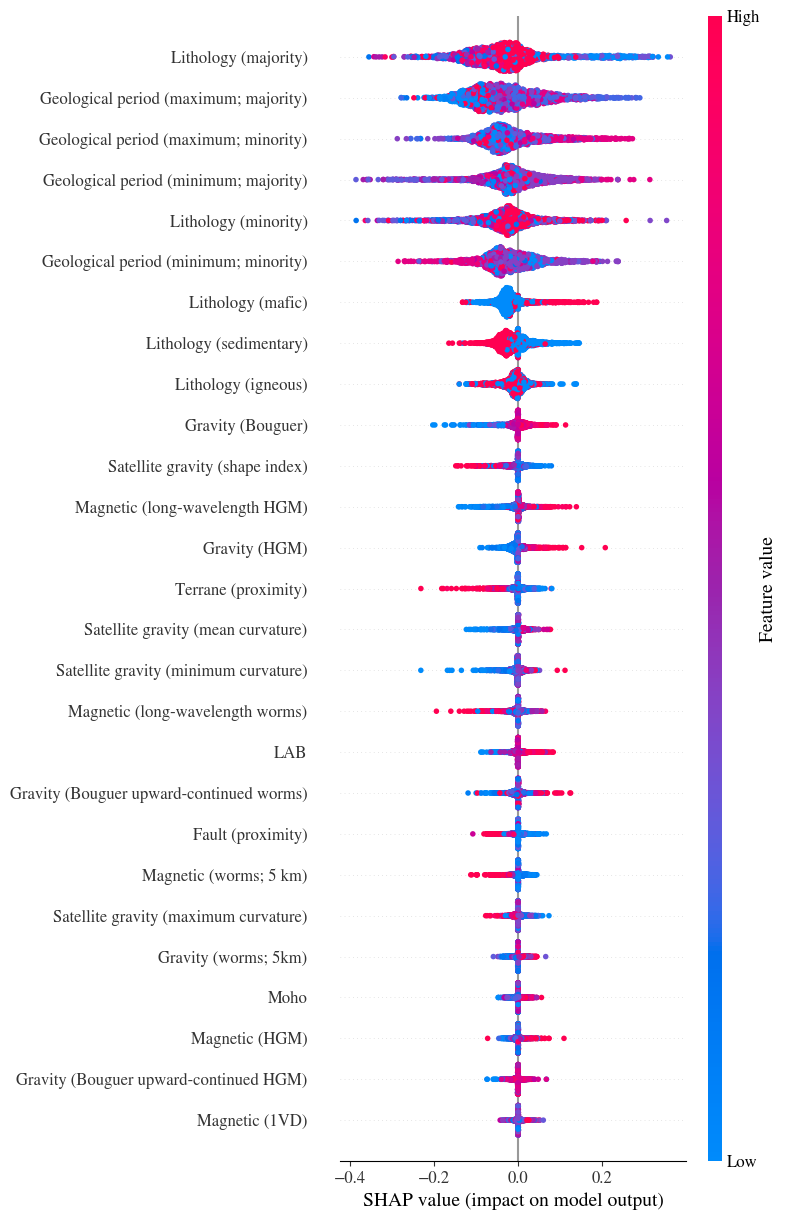

In [24]:
sorted_shap = np.load('tagi_sorted_shap.npy')
sorted_features = np.load('tagi_sorted_features.npy')
with open('tagi_sorted_names.pkl', 'rb') as f:
    sorted_names = pickle.load(f)

shap.summary_plot(
    sorted_shap, 
    sorted_features, 
    feature_names=sorted_names,
    show=False,
    max_display=29
)

plt.xlabel("SHAP value (impact on model output)", fontsize=14)
plt.tick_params(axis="both", which="major", labelsize=12)
ax = plt.gca()
ax.yaxis.label.set_size(14) 
ax.xaxis.label.set_size(14) 

cbar = plt.gcf().axes[-1]
cbar.tick_params(labelsize=12)
cbar.set_ylabel("Feature value", size=14)

plt.tight_layout()
plt.savefig('mpm_tagi_shap_consistent_font.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
sample_idx = 0                         
fp = shap.force_plot(
        explainer.expected_value,    
        agg_shap_values[sample_idx],   
        agg_features[sample_idx],       
        feature_names = agg_feature_names,
        link = "identity"              
)
fp

In [26]:
rows = slice(0, 200)

fp_many = shap.force_plot(
    explainer.expected_value,
    agg_shap_values[rows, :],
    agg_features[rows, :],
    feature_names = agg_feature_names,
    link = "identity")
fp_many               
shap.save_html("force_plot_200rows.html", fp_many)

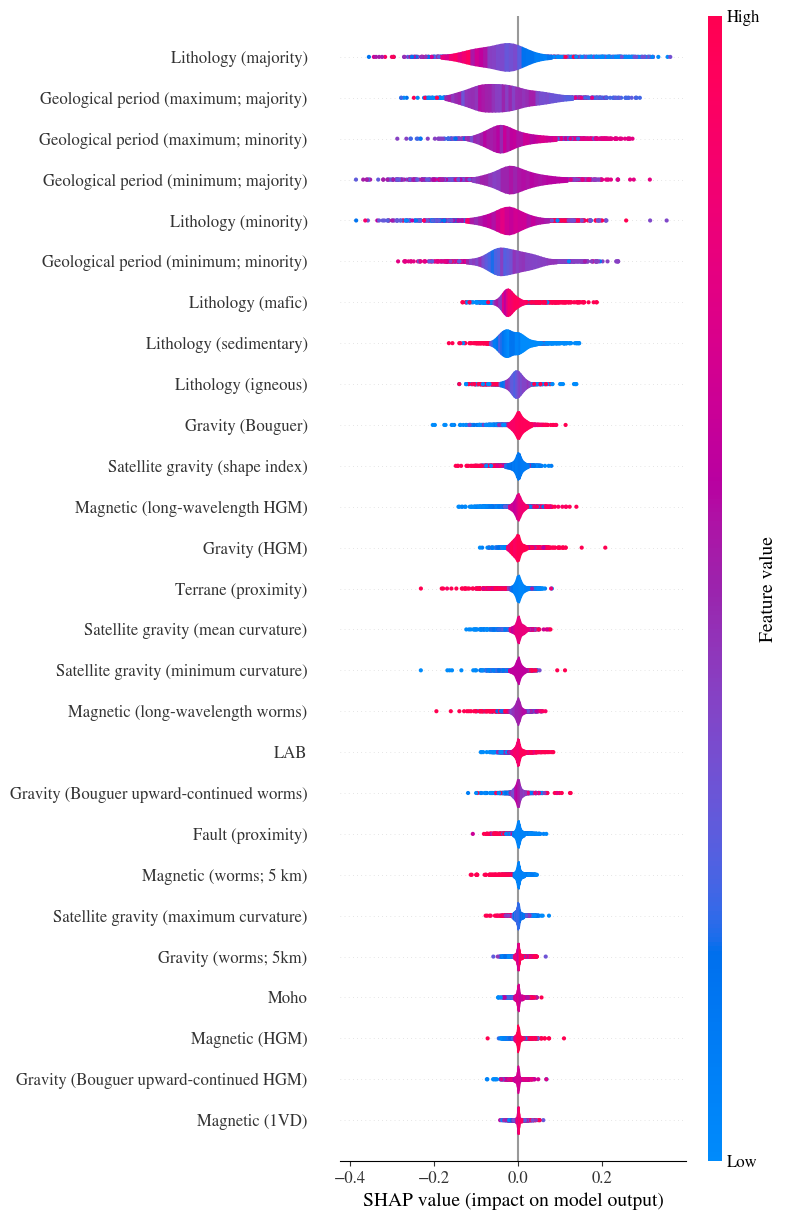

In [27]:
sorted_shap = np.load('tagi_sorted_shap.npy')
sorted_features = np.load('tagi_sorted_features.npy')
with open('tagi_sorted_names.pkl', 'rb') as f:
    sorted_names = pickle.load(f)

shap.summary_plot(
    sorted_shap, 
    sorted_features, 
    feature_names=sorted_names,
    plot_type="violin", 
    show=False,
    max_display=29
)

plt.xlabel("SHAP value (impact on model output)", fontsize=14)
plt.tick_params(axis="both", which="major", labelsize=12)
ax = plt.gca() 
#ax.set_title("SHAP Feature Importance (Violin)", fontsize=16)
ax.yaxis.label.set_size(14) 
ax.xaxis.label.set_size(14) 

cbar = plt.gcf().axes[-1]
cbar.tick_params(labelsize=12)
cbar.set_ylabel("Feature value", size=14)

plt.tight_layout()
plt.savefig('mpm_tagi_shap_violin.pdf', dpi=300, bbox_inches='tight')
plt.show()

### SHAP for uncertainty 

In [15]:
X_train_orig = torch.load('./data/dataset_train.pt').numpy().astype(np.float32)
y_train_orig = torch.load('./data/mineral_train.pt').numpy().ravel()
X_test = torch.load('./data/dataset_test.pt').numpy().astype(np.float32)

bg_idx, _  = sample_representation(
    X_train_orig, y_train_orig,
    n_background=1000, n_explain=0) 
background_data = X_train_orig[bg_idx]

ex_idx = np.load('tagi_explanation_indices.npy')

explain_data = X_test[ex_idx]

Available samples - Class 0: 1490171, Class 1: 1056


In [16]:
def get_model_uncertainty(net, X):
    net.eval()
    batch_size = 32
    all_uncertainties = []
    
    num_samples = X.shape[0]
    num_batches = (num_samples + batch_size - 1) // batch_size
    
    for i in tqdm(range(num_batches), desc="Getting model log uncertainties", leave=False):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, num_samples)
        batch_X = X[start_idx:end_idx].astype(np.float32)
        
        m_pred, v_pred = net(batch_X)
        
        utils = Utils()
        hrc_softmax = utils.get_hierarchical_softmax(num_classes=2)
        batch_size_local = m_pred.shape[0] // hrc_softmax.len
        
        # Mean variance across hierarchical components
        variances = v_pred.reshape(batch_size_local, -1).mean(axis=1)
        
        # log_var
        log_variances = np.log(variances + 1e-8)
        
        all_uncertainties.extend(log_variances)
    
    return np.array(all_uncertainties)


In [17]:
class TagiUncertaintyExplainer:
    def __init__(self, model):
        self.model = model
        
    def __call__(self, X):
        if isinstance(X, list):
            X = np.array(X)
        return get_model_uncertainty(self.model, X)


In [18]:
uncertainty_wrapper = TagiUncertaintyExplainer(net)

# background_uncertainties = get_model_uncertainty(net, background_data)
# explain_uncertainties = get_model_uncertainty(net, explain_data)

In [ ]:
uncertainty_explainer = shap.KernelExplainer(uncertainty_wrapper, background_data, link="identity")

uncertainty_shap_values = uncertainty_explainer.shap_values(explain_data, nsamples=1000, l1_reg="aic")


In [33]:
agg_uncertainty_shap_values = []

for sample_idx in range(uncertainty_shap_values.shape[0]):
    sample_agg_shap = []
    
    # Non-encoded features
    for feature_name, idx in non_encoded_indices.items():
        sample_agg_shap.append(uncertainty_shap_values[sample_idx, idx])
    
    # Categorical features
    for i, (category_name, index_range) in enumerate(ranges.items()):
        category_shap = uncertainty_shap_values[sample_idx, index_range]
        sample_agg_shap.append(np.sum(category_shap))
    
    agg_uncertainty_shap_values.append(sample_agg_shap)

agg_uncertainty_shap_values = np.array(agg_uncertainty_shap_values)

# Sort features by mean absolute SHAP values for log variance uncertainty
mean_abs_uncertainty_shap = np.abs(agg_uncertainty_shap_values).mean(0)
uncertainty_feature_order = np.argsort(-mean_abs_uncertainty_shap)
sorted_uncertainty_names = [agg_feature_names[i] for i in uncertainty_feature_order]
sorted_uncertainty_shap = agg_uncertainty_shap_values[:, uncertainty_feature_order]
sorted_uncertainty_features = agg_features[:, uncertainty_feature_order]

np.save('tagi_sorted_uncertainty_shap.npy', sorted_uncertainty_shap)
np.save('tagi_sorted_uncertainty_features.npy', sorted_uncertainty_features)
with open('tagi_sorted_uncertainty_names.pkl', 'wb') as f:
    pickle.dump(sorted_uncertainty_names, f)

Loading pre-computed SHAP uncertainty results...


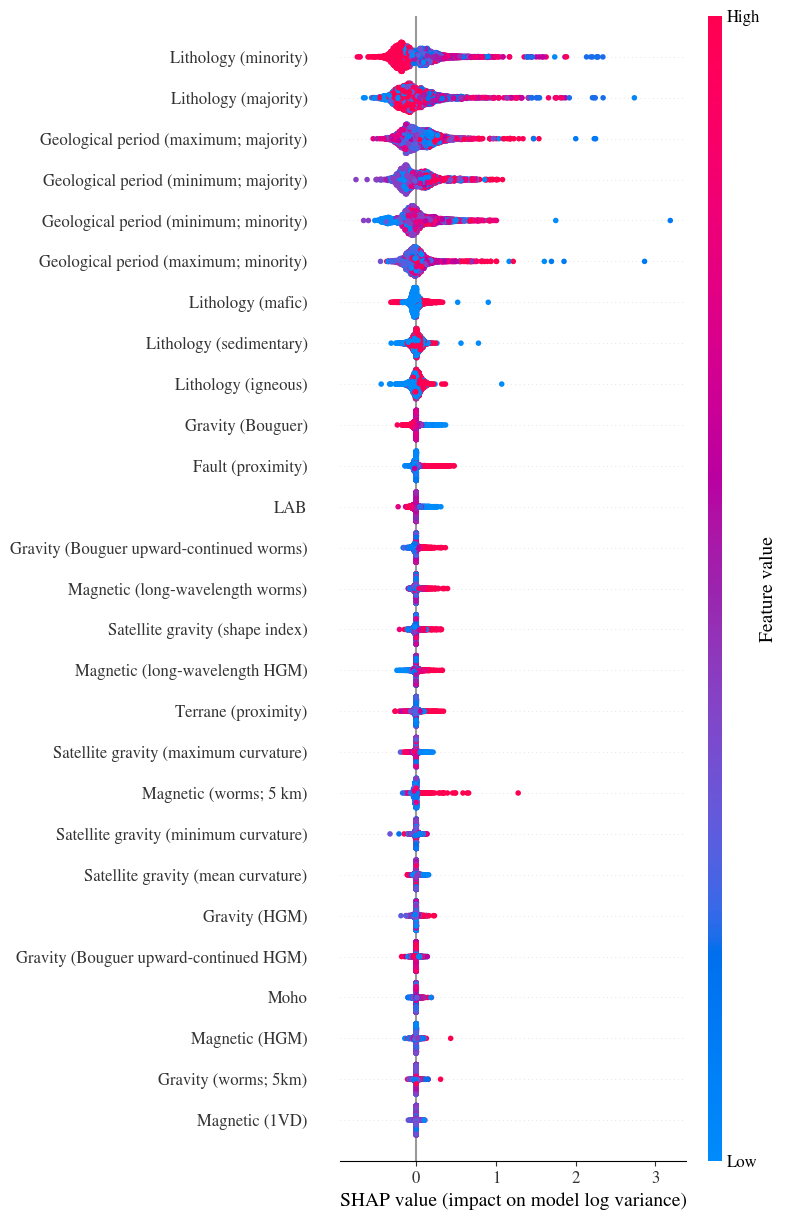

In [ ]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'STIXGeneral'

sorted_uncertainty_shap = np.load('tagi_sorted_uncertainty_shap.npy')
sorted_uncertainty_features = np.load('tagi_sorted_uncertainty_features.npy')
with open('tagi_sorted_uncertainty_names.pkl', 'rb') as f:
    sorted_uncertainty_names = pickle.load(f)


shap.summary_plot(
    sorted_uncertainty_shap,
    sorted_uncertainty_features,
    feature_names=sorted_uncertainty_names,
    show=False,
    max_display=29
)

plt.xlabel("SHAP value (impact on model log variance)", fontsize=14)
plt.tick_params(axis="both", which="major", labelsize=12)
ax = plt.gca() # Get current axes
ax.yaxis.label.set_size(14)
ax.xaxis.label.set_size(14)

cbar = plt.gcf().axes[-1]
cbar.tick_params(labelsize=12)
cbar.set_ylabel("Feature value", size=14)

plt.tight_layout()
plt.savefig('mpm_tagi_uncertainty_shap_consistent_font.pdf', dpi=300, bbox_inches='tight')
plt.show()

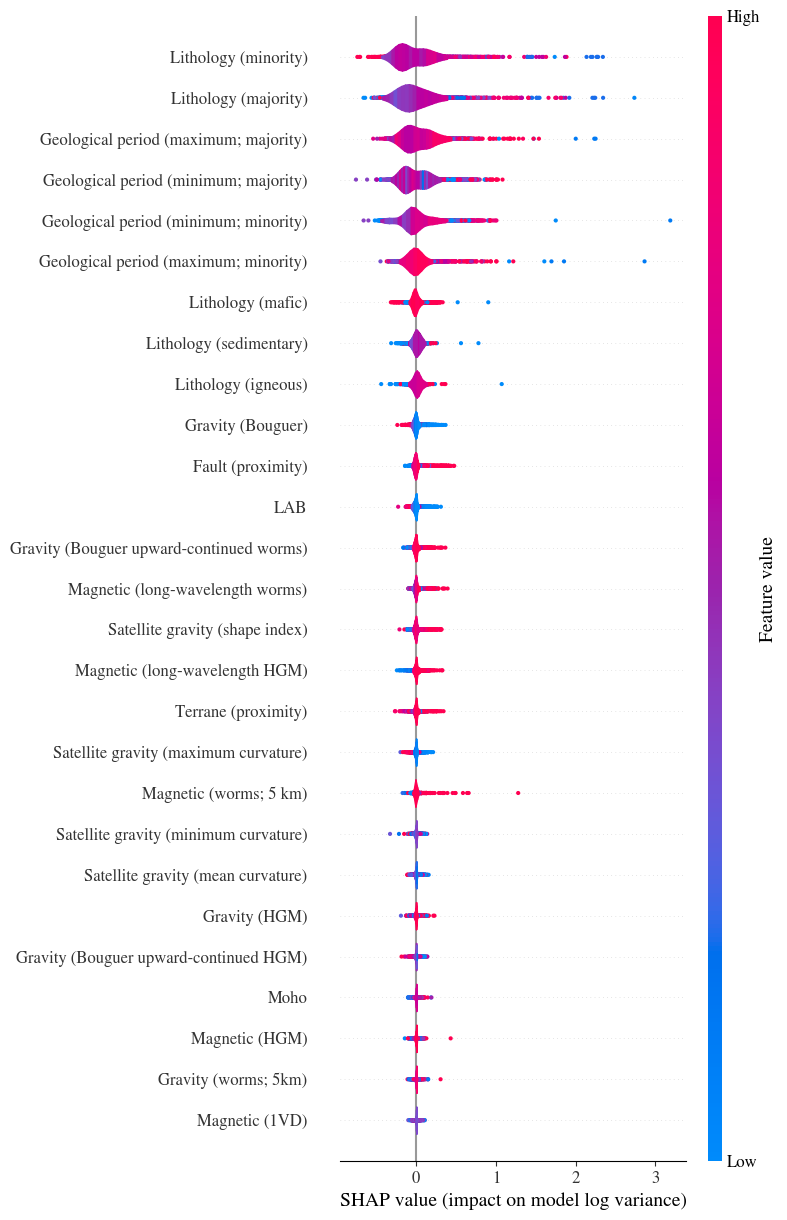

In [35]:
sorted_uncertainty_shap = np.load('tagi_sorted_uncertainty_shap.npy')
sorted_uncertainty_features = np.load('tagi_sorted_uncertainty_features.npy')
with open('tagi_sorted_uncertainty_names.pkl', 'rb') as f:
    sorted_uncertainty_names = pickle.load(f)

shap.summary_plot(
    sorted_uncertainty_shap, 
    sorted_uncertainty_features, 
    feature_names=sorted_uncertainty_names,
    plot_type="violin", 
    show=False,
    max_display=29
)

plt.xlabel("SHAP value (impact on model log variance)", fontsize=14)
plt.tick_params(axis="both", which="major", labelsize=12)
ax = plt.gca()
#ax.set_title("SHAP Uncertainty Importance (Violin)", fontsize=16)
ax.yaxis.label.set_size(14) 
ax.xaxis.label.set_size(14) 

cbar = plt.gcf().axes[-1]
cbar.tick_params(labelsize=12)
cbar.set_ylabel("Feature value", size=14)

plt.tight_layout()
plt.savefig('mpm_tagi_uncertainty_shap_violin.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [17]:
gpkg_path = "data/datacube_mpm.gpkg"
output_dir = "data"
output_path = os.path.join(output_dir, "test_h3_indices.npy")


full_gdf = gpd.read_file(gpkg_path)

full_gdf.reset_index(inplace=True)
full_gdf.rename(columns={'index': 'unique_id'}, inplace=True)

test_gdf = full_gdf[full_gdf['Train'] == 'test']

test_ids = test_gdf['unique_id'].values
np.save(output_path, test_ids)

In [18]:
ex_idx = np.load('tagi_explanation_indices.npy')
sorted_uncertainty_shap = np.load('tagi_sorted_uncertainty_shap.npy')
with open('tagi_sorted_uncertainty_names.pkl', 'rb') as f:
    sorted_uncertainty_names = pickle.load(f)

full_gdf = gpd.read_file("data/datacube_mpm.gpkg")
test_gdf = full_gdf[full_gdf['Train'] == 'test'].copy()
test_gdf.reset_index(drop=True, inplace=True)

explanation_gdf = test_gdf.iloc[ex_idx].copy()

dominant_indices = np.argmax(np.abs(sorted_uncertainty_shap), axis=1)
dominant_drivers = [sorted_uncertainty_names[i] for i in dominant_indices]
explanation_gdf['Dominant_Driver'] = dominant_drivers

output_filename = "uncer_factors.gpkg"
explanation_gdf.to_file(output_filename, driver="GPKG", layer="dominant_drivers")